In [1]:
! which pip && which python

/home/buka2004/PTQ-LLM-MIPT/.venv10/bin/pip
/home/buka2004/PTQ-LLM-MIPT/.venv10/bin/python


# Imports

In [2]:
import sys
sys.path.append('/home/buka2004/RAW-DEALL/')
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from src.model import NAFNet
from src.loss import Lasso, LassoLPIPS
from src.dataset import RAWDataset
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import os
from src.BM3D import BM3D_Step1, BM3D_Step2
import matplotlib.pyplot as plt

# Process

In [ ]:
def estimate_noise_variance_mad(image_tensor):
    """
    Estimate Gaussian noise variance using Median Absolute Deviation (MAD)
    Works best for natural images with smooth areas
    
    Args:
        image_tensor: (C, H, W) or (H, W, C) tensor in range [0, 1] or [0, 255]
    
    Returns:
        variance_estimate: estimated noise variance
    """
    
    h_diff = image_tensor[:, :, 1:] - image_tensor[:, :, :-1]
    v_diff = image_tensor[:, 1:, :] - image_tensor[:, :-1, :]
    
    diffs = torch.cat([h_diff.flatten(), v_diff.flatten()])
    
    median_val = torch.median(diffs)
    mad = torch.median(torch.abs(diffs - median_val))
    sigma_estimate = 1.4826 * mad
    
    return sigma_estimate.item() ** 2

In [4]:
dataset=[
    "/home/buka2004/RAW-DEALL/data/train/iphone-x",
    "/home/buka2004/RAW-DEALL/data/train/lq-iphone",
    "/home/buka2004/RAW-DEALL/data/train/lq-samsung",
    "/home/buka2004/RAW-DEALL/data/train/samsung-s9"
]
patch_size=1024

full_dataset = RAWDataset(dataset, patch_size=patch_size, aug_p=0.0)

dataloader = DataLoader(full_dataset, batch_size=1, shuffle=True, 
                        num_workers=4, pin_memory=True)

In [5]:
# pbar = tqdm(dataloader, desc='Validation')
# for batch in pbar:
#     dataset_path = batch['dataset']
#     srgb = batch['srgb']

batch = next(iter(dataloader))

In [ ]:
path = batch['srgb_path'][0]
clear_path = path.replace('.png', '_clear.png')
img = batch['srgb'][0]
img_np = np.clip(np.array(255 * img.permute(1,2,0).cpu()), 0.0, 255.0)

/tmp/ipykernel_1137135/3437912356.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img_np = np.clip(np.array(255 * img.permute(1,2,0).cpu()), 0.0, 255.0)


In [7]:
clear_path

'/home/buka2004/RAW-DEALL/data/train/iphone-x/0122_2_clear.png'

In [8]:
img_np.shape, np.min(img_np), np.max(img_np)

((512, 512, 3), np.float32(7.0), np.float32(226.0))

In [9]:
estimate_noise_variance_mad(img)

0.0012169424625324693

In [10]:
def apply_bm3d(img):
  H, W, C = img.shape
  result = np.zeros_like(img)
  for c in range(C):
    img_c = img[..., c]
    img_clear = BM3D_Step1(img_c)
    img_clear = BM3D_Step2(img_clear, img_c)
    result[..., c] = img_clear
  return result

In [11]:
img_clear = apply_bm3d(img_np)

In [12]:
np.max(np.abs(img_clear - img_np))

np.float32(226.0)

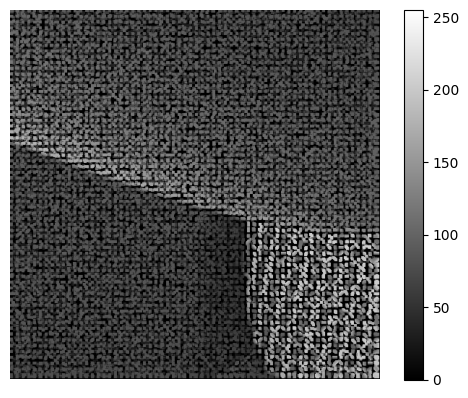

In [13]:
plt.imshow(np.mean(img_clear, axis=2), cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.axis('off')
plt.show()

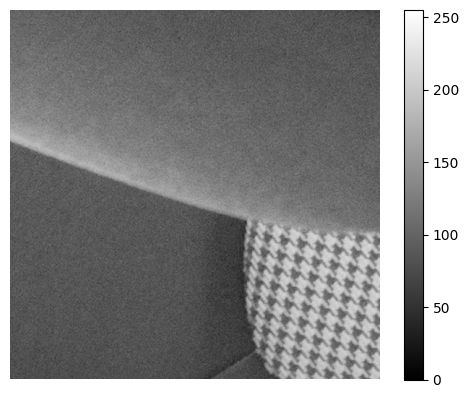

In [14]:
plt.imshow(np.mean(img_np, axis=2), cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.axis('off')
plt.show()

In [15]:
path.replace(".png", "_clear.png")

'/home/buka2004/RAW-DEALL/data/train/iphone-x/0122_2_clear.png'